In [1]:
from sklearn.datasets import fetch_california_housing 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
df= fetch_california_housing(as_frame=True).frame
df['Target'] = fetch_california_housing()['target']

In [3]:
fetch_california_housing()['target']

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [4]:
rng = np.random.RandomState(0)
indices = rng.choice(
    np.arange(df.shape[0]), size=500, replace=False
)

C:\programs\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


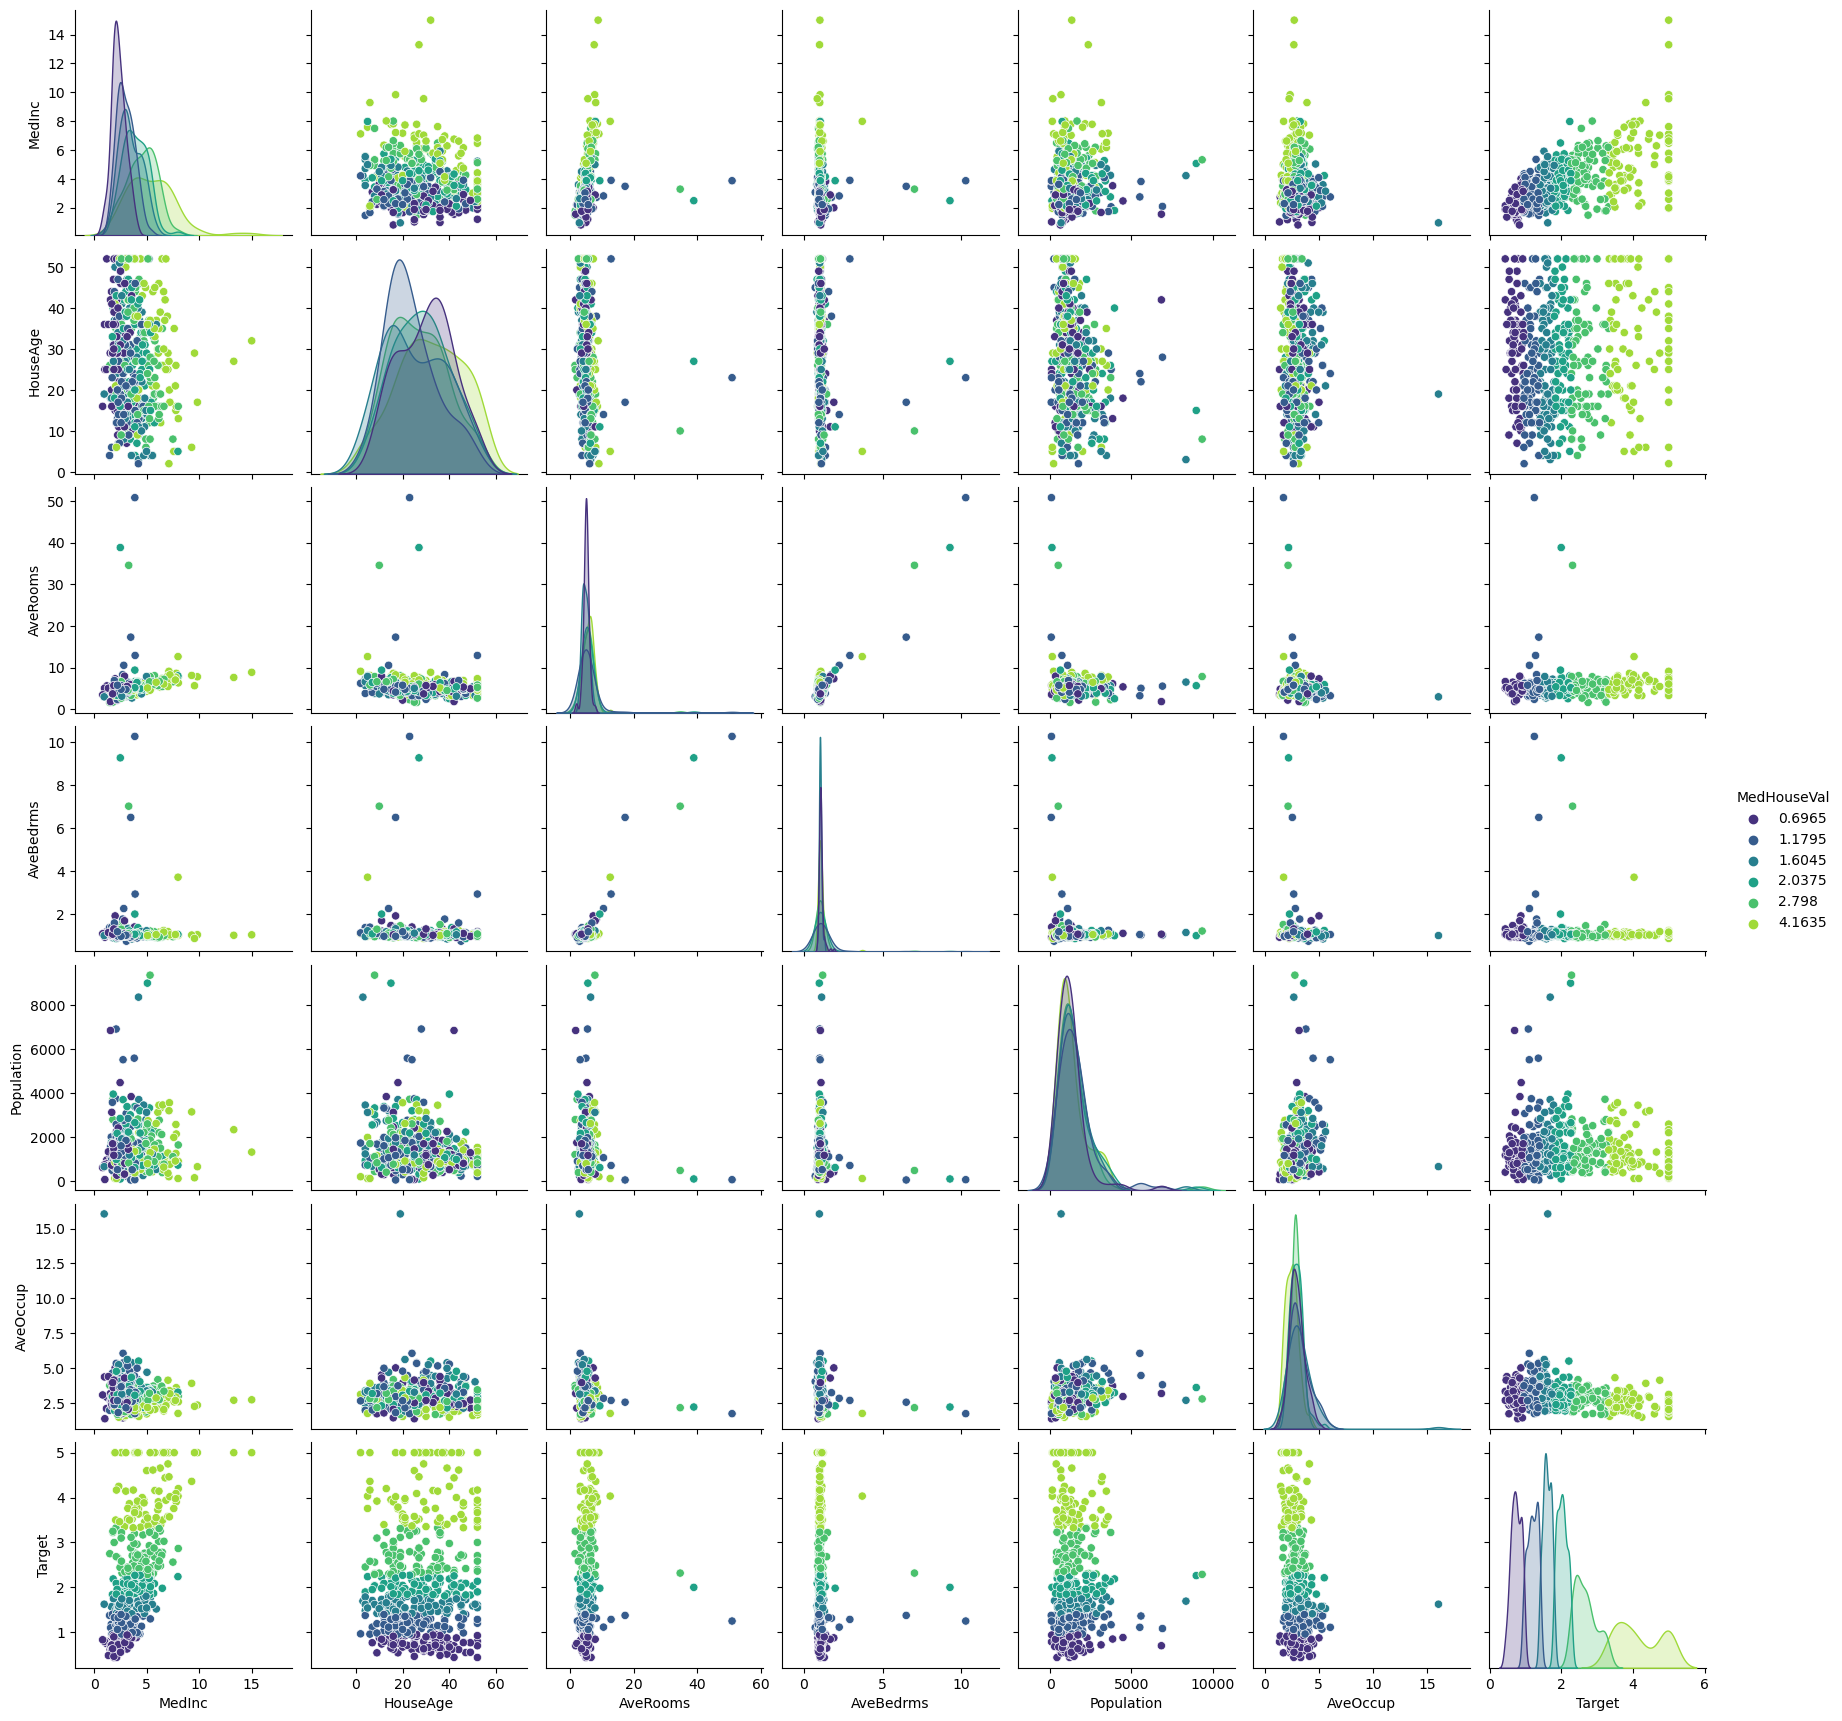

In [5]:
columns_drop = ["Longitude", "Latitude"]
subset = df.iloc[indices].drop(columns=columns_drop)
subset["MedHouseVal"] = pd.qcut(subset["MedHouseVal"], 6, retbins=False)
subset["MedHouseVal"] = subset["MedHouseVal"].apply(lambda x: x.mid)
sns.pairplot(data=subset, hue="MedHouseVal", palette="viridis")

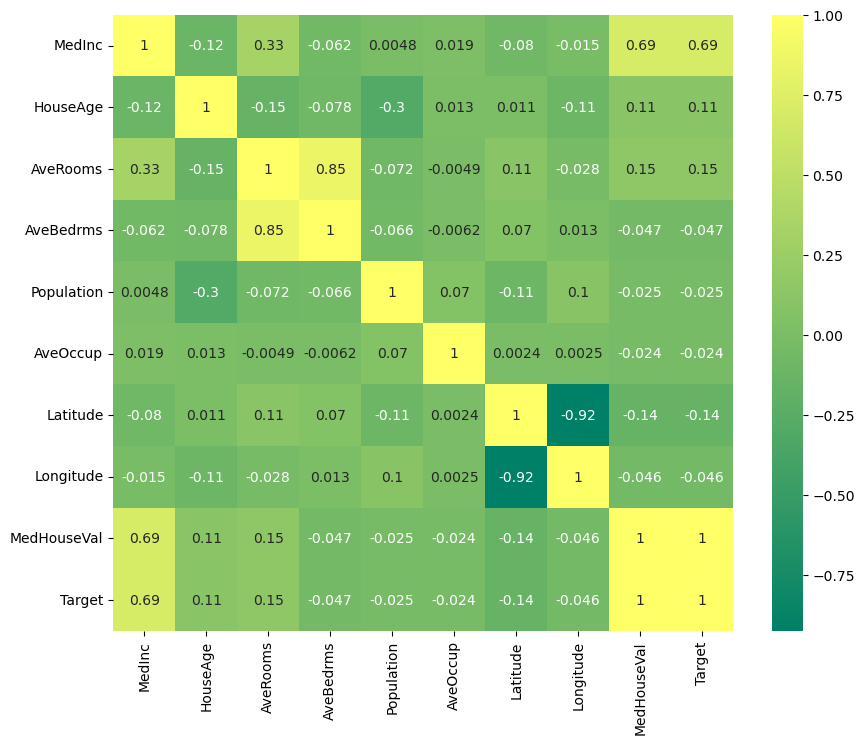

In [6]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='summer')

plt.show()

In [9]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

In [10]:

chi_square_value, p_value = calculate_bartlett_sphericity(df)
kmo_all, kmo_model = calculate_kmo(df[np.setdiff1d(df.columns, 'Target')])
print('Бартлетт хи-квадрат: %.1f c p=%.2f; КМО: %.3f'% (chi_square_value, p_value, kmo_model))

Бартлетт хи-квадрат: nan c p=nan; КМО: 0.397


C:\programs\anaconda3\lib\site-packages\factor_analyzer\factor_analyzer.py:109: RuntimeWarning: invalid value encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


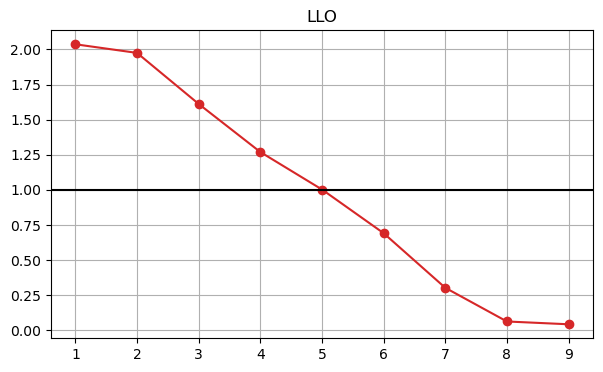

In [11]:
fa = FactorAnalyzer()
fa.fit(df[np.setdiff1d(df.columns, 'Target')])
ev, v = fa.get_eigenvalues()

plt.subplots(figsize=(7, 4), dpi=100)

plt.plot(range(1, df.shape[1]), ev, marker='o', color='tab:red')

plt.title('LLO')

plt.axhline(y=1, c='black')
plt.grid()
plt.show()

In [12]:
X = df.drop(['MedHouseVal'], axis=1)
y = df['MedHouseVal']

In [13]:
fa = FactorAnalyzer()
fa.set_params(n_factors=3, rotation='varimax')

fa.fit(X)
loadings = np.abs(fa.loadings_).tolist()
for load, feature in zip(loadings, X.columns):
    load.append(feature)

cols = [f'Factor {i + 1}' for i in range(3)]
cols.append('Feature')

load_df = pd.DataFrame(loadings, columns=cols)
load_df

,Factor 1,Factor 2,Factor 3,Feature
0,0.006948,0.074675,0.996779,MedInc
1,0.075056,0.130175,0.025157,HouseAge
2,0.112696,0.966648,0.245995,AveRooms
3,0.063385,0.888607,0.103112,AveBedrms
4,0.123291,0.041011,0.004354,Population
5,0.004065,0.007328,0.001376,AveOccup
6,0.933052,0.020505,0.104868,Latitude
7,0.993509,0.093722,0.048849,Longitude
8,0.022567,0.006185,0.689088,Target


<Axes: ylabel='Feature'>

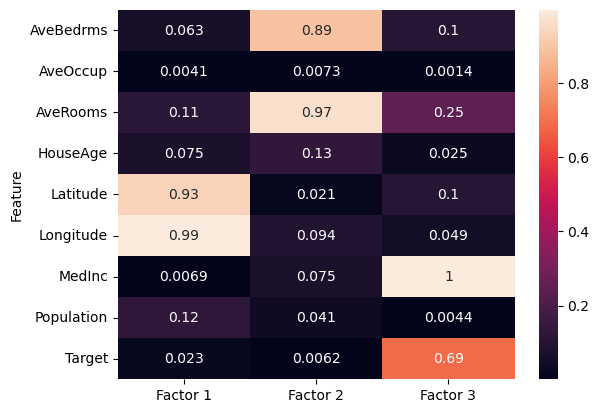

In [14]:

sns.heatmap(load_df.pivot_table(index='Feature'), annot=True)

In [15]:
fv = fa.get_factor_variance()
pd.DataFrame(fv, columns=[f'Factor {i + 1}' for i in range(3)])

,Factor 1,Factor 2,Factor 3
0,1.895773,1.757530,1.553594
1,0.210641,0.195281,0.172622
2,0.210641,0.405923,0.578544


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_factor = fa.transform(X_train)
X_factor_test = fa.transform(X_test)

In [19]:

from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=1000,
    depth=4,
    learning_rate=0.01,
    loss_function='RMSE',
    verbose=200
)
model.fit(X_factor, y_train)

0:	learn: 1.1489793	total: 147ms	remaining: 2m 26s
200:	learn: 0.8183481	total: 570ms	remaining: 2.26s
400:	learn: 0.7862417	total: 981ms	remaining: 1.47s
600:	learn: 0.7740808	total: 1.39s	remaining: 923ms
800:	learn: 0.7667740	total: 1.8s	remaining: 448ms
999:	learn: 0.7608062	total: 2.21s	remaining: 0us


In [20]:
predictions = model.predict(X_factor_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f'Test RMSE: {rmse:.2f}')

Test RMSE: 0.78


In [21]:
predictions = model.predict(X_test)

# Оценка качества модели
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f'Test RMSE: {rmse:.2f}')

Test RMSE: 2.16
